In [1]:
#Import libraries
import csv
import pandas as pd
import pygal

In [2]:
#Read in the data
data = pd.read_csv("sleepdata.csv", usecols=["Start", "End", "Sleep quality", "Time in bed", "Wake up", "Activity (steps)"])

In [3]:
#Scrub the data
data.fillna(":|", inplace=True)

for index, row in data.iterrows():
    data.set_value(index, 'Sleep quality', row["Sleep quality"].replace("%", ""))

In [4]:
#Convert columns to proper data types
data["Start"] = pd.to_datetime(data["Start"])
data["End"] = pd.to_datetime(data["End"])
data["Sleep quality"] = pd.to_numeric(data["Sleep quality"])
data["Activity (steps)"] = pd.to_numeric(data["Activity (steps)"])

In [5]:
#Calculate time in bed in minutes
data["Time in bed (minutes)"] = data["Time in bed"]
for index, row in data.iterrows():
    minutes = (int(row["Time in bed (minutes)"][0:row["Time in bed (minutes)"].index(":")])*60) + int(row["Time in bed (minutes)"][row["Time in bed (minutes)"].index(":")+1:]) 
    data.set_value(index, 'Time in bed (minutes)', minutes)
data["Time in bed (minutes)"] = pd.to_numeric(data["Time in bed (minutes)"])

In [6]:
#Drop rows that have no minutes recorded in bed
data = data.drop([592,660,858,237])

In [7]:
#Add additional date columns
data["Start Weekday"] = data["Start"].dt.dayofweek
data["Start Year"] = data["Start"].dt.year
data["Start Month"] = data["Start"].dt.month
data["Start Day"] = data["Start"].dt.day

In [8]:
#Convert wake up data into human readable strings
for index, row in data.iterrows():
    if (row["Wake up"] == ":)"):
        mood = "Good"
    elif (row["Wake up"] == ":("):
        mood = "Bad"
    else:
        mood = "Neutral"
    data.set_value(index, 'Mood', mood)

In [9]:
#pygal inline visualization setup
%matplotlib inline
from IPython.display import SVG, HTML

html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [10]:
#Create data variables for each year
data2017 = data.loc[data["Start"] >= '2017-01-01']
data2016 = data.loc[(data["Start"] >= '2016-01-01') & (data["Start"] <= '2016-12-31')]
data2015 = data.loc[data["Start"] < '2016-01-01']

In [11]:
#Sleep quality over time (2017 only)
plot = pygal.Line(show_x_labels=False)
plot.legend_at_bottom = True
plot.title = "Sleep Quality by Night (2017)"
#plot.x_labels = map(lambda d: d.strftime('%b %Y'), data2017["Start"])
plot.add("2017", data2017["Sleep quality"])
HTML(html_pygal.format(pygal_render=plot.render()))

In [12]:
#Box plot 
plot = pygal.Box()
plot.title = "Distribution of Sleep Quality by Year"
plot.add("2017", data2017["Sleep quality"])
plot.add("2016", data2016["Sleep quality"])
plot.add("2015", data2015["Sleep quality"])
HTML(html_pygal.format(pygal_render=plot.render()))

In [13]:
#Dot chart of sleep quality by day of week
plot = pygal.Dot()
plot.title = "Sleep Quality by Day of Week"
plot.x_labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plot.add("Sleep quality", data.groupby("Start Weekday")["Sleep quality"].mean())
#plot.add("Sunday", data.loc[data["Start Weekday"] == 0]["Sleep quality"].mean())
#plot.add("Monday", data.loc[data["Start Weekday"] == 1]["Sleep quality"].mean())
#plot.add("Tuesday", data.loc[data["Start Weekday"] == 2]["Sleep quality"].mean())
#plot.add("Wednesday", data.loc[data["Start Weekday"] == 3]["Sleep quality"].mean())
#plot.add("Thursday", data.loc[data["Start Weekday"] == 4]["Sleep quality"].mean())
#plot.add("Friday", data.loc[data["Start Weekday"] == 5]["Sleep quality"].mean())
#plot.add("Saturday", data.loc[data["Start Weekday"] == 6]["Sleep quality"].mean())
HTML(html_pygal.format(pygal_render=plot.render()))

In [14]:
#Radar chart of sleep quality by month
plot = pygal.Radar()
plot.title = "Sleep Quality by Month"
plot.x_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plot.add("2017", data2017.groupby("Start Month")["Sleep quality"].mean())
plot.add("2016", data2016.groupby("Start Month")["Sleep quality"].mean())
plot.add("2015", data2015.groupby("Start Month")["Sleep quality"].mean())
HTML(html_pygal.format(pygal_render=plot.render()))

In [15]:
#Radar chart of sleep quality by day of week
plot = pygal.Radar()
plot.title = "Sleep Quality by Day of Week"
plot.x_labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plot.add("2017", data2017.groupby("Start Weekday")["Sleep quality"].mean())
plot.add("2016", data2016.groupby("Start Weekday")["Sleep quality"].mean())
plot.add("2015", data2015.groupby("Start Weekday")["Sleep quality"].mean())
plot.render_to_file('quality-by-day-of-week.svg')
HTML(html_pygal.format(pygal_render=plot.render()))

In [16]:
#Donut chart of Mood breakdown
plot = pygal.Pie(inner_radius=.5)
plot.title = "Mood Counts"
plot.add("Good", data.loc[data["Mood"] == "Good"]["Mood"].count())
plot.add("Bad", data.loc[data["Mood"] == "Bad"]["Mood"].count())
plot.add("Neutral", data.loc[data["Mood"] == "Neutral"]["Mood"].count())
plot.render_to_file('mood-counts.svg')
HTML(html_pygal.format(pygal_render=plot.render()))

In [17]:
#Stacked line chart to compare activity with time in bed by month
plot = pygal.StackedLine()
plot.title = "Activity vs. Time in Bed by Month"
plot.add("Sleep Quality", data.groupby("Start Month")["Sleep quality"].mean())
plot.add("Time in Bed", data.groupby("Start Month")["Time in bed (minutes)"].mean())
plot.add("Activity", data.groupby("Start Month")["Activity (steps)"].mean())
plot.render_to_file('activity-vs-quality.svg')
HTML(html_pygal.format(pygal_render=plot.render()))

In [18]:
#Time in bed by day of week
plot = pygal.Bar()
plot.title = "Time in Bed by Day of Week"
plot.x_labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plot.add("Time in Bed", data.groupby("Start Weekday")["Time in bed (minutes)"].mean())
HTML(html_pygal.format(pygal_render=plot.render()))

In [19]:
#Sleep quality by day of week
plot = pygal.Bar()
plot.title = "Time in Bed by Day of Week"
plot.x_labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
plot.add("Time in Bed", data.groupby("Start Weekday")["Time in bed (minutes)"].mean())
HTML(html_pygal.format(pygal_render=plot.render()))

In [21]:
goodSleep = data.loc[data["Sleep quality"] >= 85]
goodSleep.head()

,Start,End,Sleep quality,Time in bed,Wake up,Activity (steps),Time in bed (minutes),Start Weekday,Start Year,Start Month,Start Day,Mood
8,2015-01-31 22:41:35,2015-02-01 09:50:19,98,11:08,:|,1349,668,5,2015,1,31,Neutral
10,2015-02-02 22:33:50,2015-02-03 06:14:37,86,7:40,:|,1760,460,0,2015,2,2,Neutral
15,2015-02-07 23:34:11,2015-02-08 09:09:23,100,9:35,:|,1622,575,5,2015,2,7,Neutral
16,2015-02-08 21:22:49,2015-02-09 06:14:27,92,8:51,:|,2022,531,6,2015,2,8,Neutral
18,2015-02-10 22:07:50,2015-02-11 06:14:37,94,8:06,:|,2085,486,1,2015,2,10,Neutral


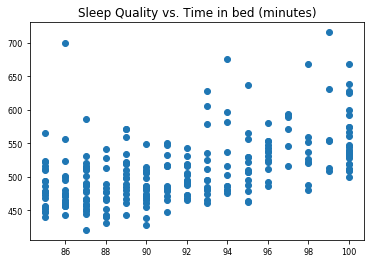

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
for i in range(1):
    x = goodSleep["Sleep quality"]
    y = goodSleep["Time in bed (minutes)"]
    ax.scatter(x,y,label=str(i))
ax.set_title("Sleep Quality vs. Time in bed (minutes)")
fig.savefig('quality-vs-time.png')

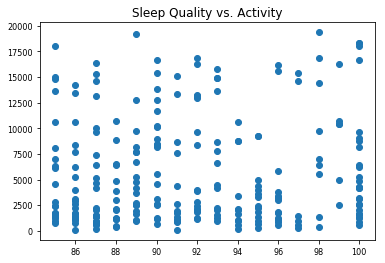

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
for i in range(1):
    x = goodSleep["Sleep quality"]
    y = goodSleep["Activity (steps)"]
    ax.scatter(x,y,label=str(i))
ax.set_title("Sleep Quality vs. Activity")
fig.savefig('quality-vs-activity.png')

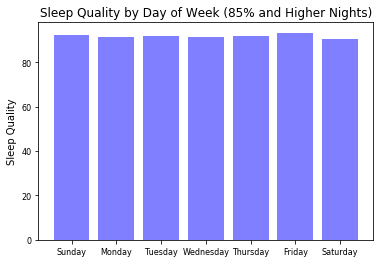

In [37]:
import matplotlib as mpl
import numpy as np

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
weekdays = ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday')
y_pos = range(len(weekdays))

plt.bar(y_pos, goodSleep.groupby("Start Weekday")["Sleep quality"].mean(), align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, weekdays)
plt.ylabel('Sleep Quality')
plt.title("Sleep Quality by Day of Week (85% and Higher Nights)")
plt.show()
plt.savefig('good-nights-by-weekday.png')